In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("bank-additional/bank-additional-full.csv", header=0, delimiter=";")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [95]:
df.default.value_counts()

default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64

column "default" is extremely unbalanced therefore can be excluded from dataset

In [3]:
import pandas as pd
def clean_data(df : pd.DataFrame, includeDefault = False, includeDate=False) -> pd.DataFrame:
    df_cleaned = df.copy()
    df_cleaned['y'] = df_cleaned['y'].map({'yes': 1, 'no': 0})

    if (not includeDefault):
        df_cleaned = df_cleaned.drop('default', axis=1)

    if (not includeDate):
        df_cleaned = df_cleaned.drop(['day_of_week', 'month'], axis=1)

    return df_cleaned


## Data Preprocessing

### Encoding Categorical Data

In [4]:
import pandas as pd
def preprocess_data(data : pd.DataFrame, includeDate = False) -> pd.DataFrame:
    dummies_contact = pd.get_dummies(data['contact'], prefix='contact', drop_first=True)

    dummies_house = pd.get_dummies(data['housing'], prefix='housing')
    dummies_house = dummies_house.drop('housing_unknown', axis=1)

    dummies_loan = pd.get_dummies(data['loan'], prefix='loan')
    dummies_loan  = dummies_loan.drop('loan_unknown', axis=1)


    dummies_marital = pd.get_dummies(data['marital'], prefix='marital')
    dummies_marital  = dummies_marital.drop('marital_unknown', axis=1)

    dummies_education = pd.get_dummies(data['education'], prefix='education')
    dummies_education  = dummies_education.drop('education_unknown', axis=1)

    dummies_job = pd.get_dummies(data['job'], prefix='job')
    dummies_job  = dummies_job.drop('job_unknown', axis=1)


    dummies_poutcome = pd.get_dummies(data['poutcome'], prefix='poutcome')
    dummies_poutcome  = dummies_poutcome.drop('poutcome_nonexistent', axis=1)


    df_encoded = pd.concat([
        data,
        dummies_contact,
        dummies_house,
        dummies_loan,
        dummies_marital,
        dummies_education,
        dummies_job,
        dummies_poutcome
    ], axis=1).drop([
        'contact',
        'housing',
        'loan',
        'marital', 
        'education', 
        'job', 
        'poutcome', 
    ], axis=1)

    if 'month' in data.columns:
        dummies_month = pd.get_dummies(data['month'], prefix='month', drop_first=True)
        dummies_day_of_week = pd.get_dummies(data['day_of_week'], prefix='day_of_week', drop_first=True)

        df_encoded = pd.concat([
            df_encoded,
            dummies_month,
            dummies_day_of_week
        ], axis=1).drop(['month' ,'day_of_week'], axis=1)

    if 'default' in data.columns:
        dummies_default = pd.get_dummies(data['default'], prefix='default')
        dummies_default  = dummies_default.drop('default_unknown', axis=1)
        df_encoded = pd.concat([df_encoded, dummies_default], axis=1).drop(['default'], axis=1)

    return df_encoded


### Data Scaling

In [5]:
from sklearn.model_selection import train_test_split

clean = clean_data(df)
df_encoded = preprocess_data(clean)

X_train, X_val, y_train, y_val = train_test_split(df_encoded.drop('y', axis=1), df_encoded['y'], test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_val_scaled = scaler.transform(X_val)


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_val_scaled)

### Logistic Regression Metrics

In [119]:
from sklearn.metrics import accuracy_score

accuracy_score_val = accuracy_score(y_val, y_pred)

print(accuracy_score_val)

0.911143481427531


In [ ]:

df_test = pd.read_csv('bank-additional/bank-additional.csv', delimiter=";")
clean_test = clean_data(df_test)
df_encoded_test = preprocess_data(clean_test)
X_test_scaled = scaler.transform(df_encoded_test.drop('y', axis=1))

y_pred = model.predict(X_test_scaled)

accuracy_score_test = accuracy_score(df_encoded_test['y'], y_pred)


print(accuracy_score_test)

0.9150279193979121


## Random Forest


In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)

y_pred_rf = rf.predict(X_val_scaled)

### Random Forest Metrics

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

accuracy = accuracy_score(y_val, y_pred_rf)
print("Accuracy:", accuracy)

Accuracy: 0.9127215343529983


### Random Forest Hyperparameter Tuning

In [34]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV, KFold

params = {'n_estimators' : randint(10,500),
          'max_depth': randint(1,25)}
kf = KFold(n_splits=8, shuffle=True, random_state=53)
rf_tune = RandomForestClassifier()

rand_search = RandomizedSearchCV(rf_tune,params,n_iter=60,cv=kf)
rand_search.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=KFold(n_splits=8, random_state=53, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=60,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001A6374DA5A0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001A6375AF7D0>})

#### Best Values

In [35]:
best_rf = rand_search.best_estimator_

print('Best Hyperparameters: ', rand_search.best_params_)

Best Hyperparameters:  {'max_depth': 15, 'n_estimators': 471}


#### Prediction Using The Best Forest

Accuracy: 0.9140568099053168
Precision: 0.6798732171156894
Recall: 0.4588235294117647


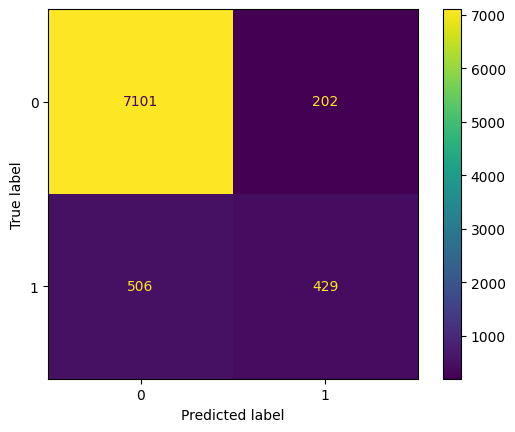

In [36]:
y_pred_best = best_rf.predict(X_val_scaled)

cm = confusion_matrix(y_val, y_pred_best)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

accuracy = accuracy_score(y_val, y_pred_best)
print("Accuracy:", accuracy)
precision = precision_score(y_val, y_pred_best)
print("Precision:", precision)
recall = recall_score(y_val, y_pred_best)
print("Recall:", recall)


#### Feature Comparison

<Axes: >

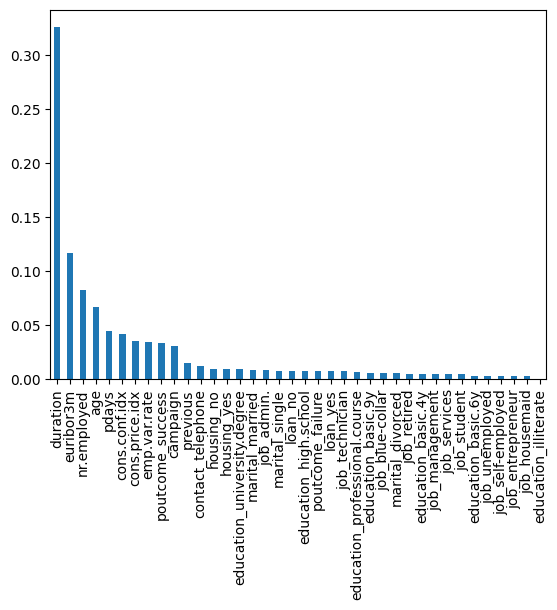

In [38]:
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.plot.bar()

#### Results

N-Iter 60 (Random State 53):
| Folds    | max_depth | n_esitmators | Accuracy         | Precision           | Recall            | Feature  |
| -------- | -------   | -------      | -------          | -------             | -------           |-         |
| 6        | 13        | 138          |0.9133284777858703| 0.6942003514938488  |0.42245989304812837|          | 
| 7        | 17        | 350          |0.9151493080844866| 0.6710144927536232  |0.49518716577540106|          |
| 8        | 15        | 471          |0.9140568099053168| 0.6798732171156894  |0.4588235294117647 | duration | 



N-Iter 100:
| Folds    | max_depth | n_esitmators | Accuracy         | Precision           | Recall            | Feature  |
| -------- | -------   | -------      | -------          | -------             | -------           |-         |
| 6        | 13        | 138          |0.9133284777858703| 0.6942003514938488  |0.42245989304812837|          | 
| 7        | 17        | 350          |0.9151493080844866| 0.6710144927536232  |0.49518716577540106|          |
| 8        | 15        | 471          |0.9140568099053168| 0.6798732171156894  |0.4588235294117647 | duration | 